In [601]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import pickle
import psycopg2

from src.plot_confusion_matrix import plot_confusion_matrix
%matplotlib inline
pd.options.display.max_colwidth = 50

In [539]:
# Helper Functions

def score_model(model, X_test, y_test, threshold = .5):
    probs = model.predict_proba(X_test)[:, 1]
    preds = probs.copy()
    preds[preds>=threshold] = 1
    preds[preds<threshold] = 0
    results = np.empty(preds.shape)
#     roc_curve(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    accuracy = model.score(X_test, y_test)
    print('Precision: {:.2f}\nRecall: {:.2f}\nAccuracy: {:.2f}\nThreshold: {:.2f}'.format(precision, recall, accuracy, threshold))
    
def smote_split():
#     print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
#     print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())


#     print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
#     print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

#     print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
#     print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

    return X_train_res, y_train_res

# Load Data

In [4]:
# Unzip data and put contents into the main data folder of repo
with zipfile.ZipFile('./data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [540]:
# Load json data file into Pandas Dataframe
df = pd.read_json('./data/data.json')

# Initial EDA

### Initial Takeaways
* 9.91% of the data was fraud
#### Currency
* All events of currency for MXC and NZD were fraud
#### User Type
* User type of 1 had more fraud than others, User type of 2 was all fraud (1 user)
* Most of the fraud events were user type 1 (about 900 out of about 1200)
#### Body Length
* Percent of body length 0 w/ fraud: 39.81%
* Percent of non fraud with body length 0: 60.19%
* Percent of fraud w/ body length 0: 25.52%
* Percent of non fraud with body length 0: 3.83%

#### Name Length
* At first glance, name length appears to show signal with quite different means, but they're actually within 1 STD of each other so there is not signal. 
* Plot shows this nicely

In [541]:
# Declare what is fraud based on account type
df['fraud'] = df['acct_type'].isin(['fraudster', 'fraudster_event', 'fraudster_att'])*1

In [230]:
print('There were {} cases of fraud out of {} total records.\nFraud Percent = {:.2f}%'.format(np.sum(df.fraud == 1), len(df.fraud), np.sum(df.fraud == 1)*100/len(df.fraud)))


There were 1293 cases of fraud out of 14337 total records.
Fraud Percent = 9.02%


In [165]:
body_length_fraud = np.sum(df[df.body_length==0].fraud)
body_length_not_fraud = np.sum(df.body_length==0)-body_length_fraud
body_length_0 = len(df[df.body_length==0])
total_fraud = np.sum(df.fraud)
total_not_fraud = len(df.fraud) - total_fraud
print('Percent of body length 0 w/ fraud: {:.2f}%\nPercent of non fraud with body length 0: {:.2f}%'.format(body_length_fraud*100/body_length_0, body_length_not_fraud*100/body_length_0))
print('Percent of fraud w/ body length 0: {:.2f}%\nPercent of non fraud with body length 0: {:.2f}%'.format(body_length_fraud*100/total_fraud, body_length_not_fraud*100/total_not_fraud))


Percent of body length 0 w/ fraud: 39.81%
Percent of non fraud with body length 0: 60.19%
Percent of fraud w/ body length 0: 25.52%
Percent of non fraud with body length 0: 3.83%


In [247]:
# Looking at mean values against fraud for signal
df.groupby(df.fraud==1).mean()['name_length']

#appears to be signal in 
# channels, delivery_method, body length, fb_published, gts, org_twitter, has_header, has_logo, 

# likely leakers
# sale duration, user_age, user_type

fraud
False    42.784575
True     29.975251
Name: name_length, dtype: float64

In [373]:
df[df.fraud==0].sample(10)['channels']

11225     8
7203      4
6137      6
3202     11
6850      0
11599     0
8745      5
4838     11
9504      0
6439      8
Name: channels, dtype: int64

In [396]:
def plot_distributions(feature_name, limit = None):
    

    # Take a sample from non-fraud so that peaks are more comparable
    non_fraud = pd.Series(np.random.choice(df[feature_name][df.fraud==0], 1400))

    fraud = df[feature_name][df.fraud==1]
    fraud.hist(bins = 30, label = 'Fraud')
    non_fraud.hist(bins = 30, label = 'Not Fraud', alpha = .5)
    plt.suptitle("{} Distributions".format(feature_name))
    plt.xlabel(feature_name)
    plt.ylabel('Count')
    plt.legend()
    if limit is not None:
        plt.xlim(0, limit)

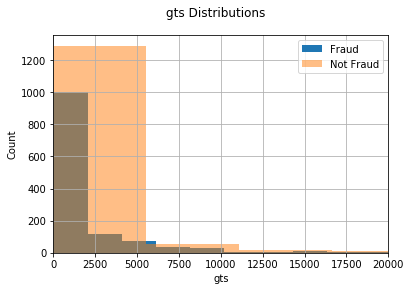

In [397]:
plot_distributions('gts', 20000)

In [232]:
df.columns

Index(['acct_type', 'approx_payout_date', 'body_length', 'channels', 'country',
       'currency', 'delivery_method', 'description', 'email_domain',
       'event_created', 'event_end', 'event_published', 'event_start',
       'fb_published', 'gts', 'has_analytics', 'has_header', 'has_logo',
       'listed', 'name', 'name_length', 'num_order', 'num_payouts',
       'object_id', 'org_desc', 'org_facebook', 'org_name', 'org_twitter',
       'payee_name', 'payout_type', 'previous_payouts', 'sale_duration',
       'sale_duration2', 'show_map', 'ticket_types', 'user_age',
       'user_created', 'user_type', 'venue_address', 'venue_country',
       'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state',
       'fraud'],
      dtype='object')

In [398]:
# Plot the distribution of fraud vs non-fraud for a feature 
mu_fraud = np.mean(df['gts'][df.fraud==1])
std_fraud = np.std(df['gts'][df.fraud==1])
mu_non_fraud = np.mean(df['gts'][df.fraud==0])
std_non_fraud = np.std(df['gts'][df.fraud==0])
print(mu_fraud)
print(std_fraud)
print(mu_non_fraud)
print(std_non_fraud)

1911.2143619489577
4637.99166684837
2481.679602115906
9470.949208526292


array([<matplotlib.axes._subplots.AxesSubplot object at 0x122ad9278>,
      dtype=object)

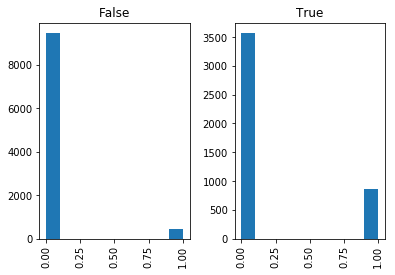

In [100]:
df.fraud.hist(df['body_length'].between(0, 1000))

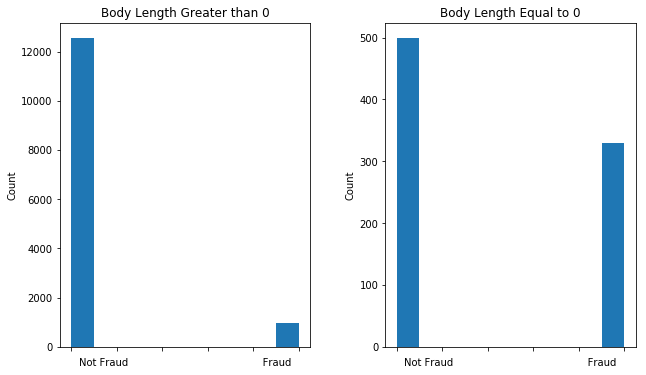

In [228]:
pd.set_option('mode.chained_assignment', None)

axes = df.fraud.hist(df['body_length']==0, figsize = (10, 6))
for idx, ax in enumerate(axes):
    if idx == 0:
        title = 'Body Length Greater than 0'
    else:
        title = 'Body Length Equal to 0'
    ax.set_title(title)
    ax.set_xlabel('Not Fraud                                           Fraud')
    ax.set_ylabel('Count')
    ax.set_xticklabels([])

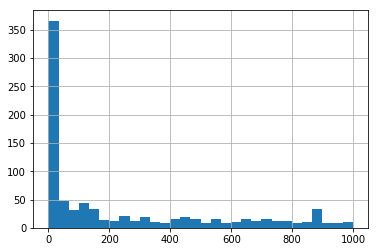

In [368]:
df.body_length[df.fraud==1][df.body_length<1000].hist(bins = 30)

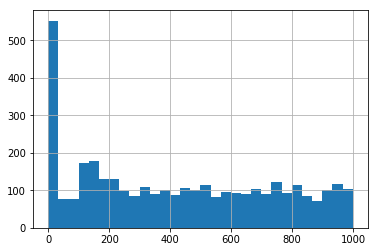

In [367]:
df.body_length[df.fraud==0][df.body_length<1000].hist(bins = 30)

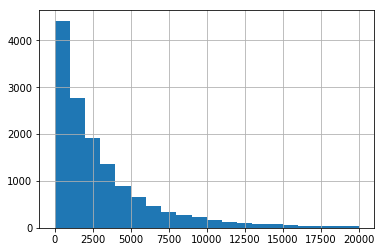

In [86]:
df.body_length[df['body_length']<20000].hist(bins = 20)

In [ ]:
# Clean outliers for user_type
df.user_type[df.user_type >= 5] = 4

1293

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a111c198>]],
      dtype=object)

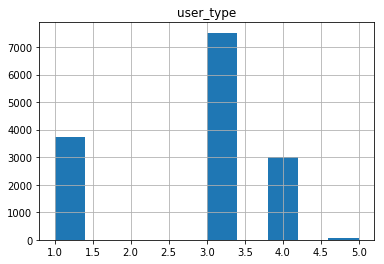

In [57]:
# check if user type has bearing on fraud
df.hist('user_type')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a235eac8>,
      dtype=object)

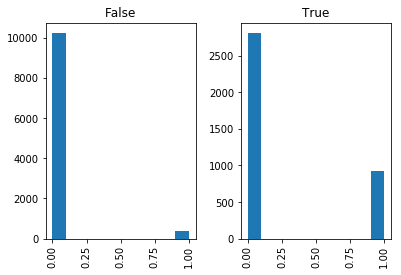

In [61]:
df.fraud.hist(df['user_type'] == 1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5462eb8>,
      dtype=object)

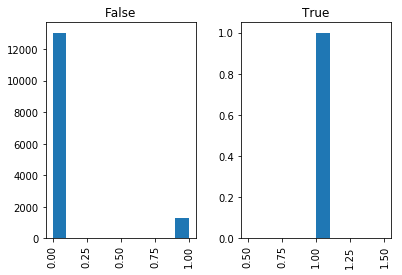

In [62]:
df.fraud.hist(df['user_type'] == 2)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a73d4940>,
      dtype=object)

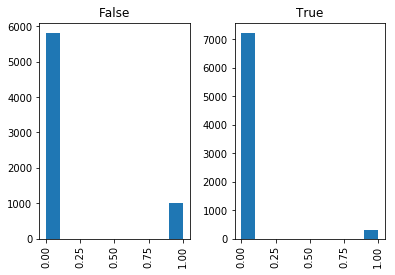

In [63]:
df.fraud.hist(df['user_type'] == 3)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a8814400>,
      dtype=object)

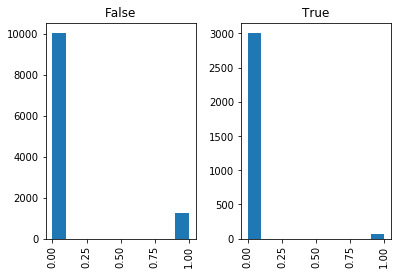

In [64]:
df.fraud.hist(df['user_type'] == 4)

# Data Pipeline Snippets

In [366]:
def _add_body_length_columns(self):
    self.DF['body_length_0'] = (self.DF['body_length'] == 0)*1
    self.DF['body_length_100'] = self.DF['body_length'].between(1, 100)*1
    self.DF['body_length_200'] = self.DF['body_length'].between(101, 200)*1
    self.DF['body_length_long'] = (self.DF['body_length']>200)*1

In [384]:
df['channel_0'] = (df['channels'] == 0)*1
df['channel_8'] = (df['channels'] == 8)*1
df['channel_other'] = (~df['channels'].isin([0, 8]))*1

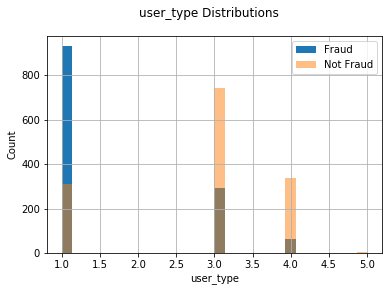

In [542]:
plot_distributions('user_type')

In [543]:
df['user_type_1'] = (df['user_type']==1)*1
df['user_type_2'] = (df['user_type']==2)*1
df['user_type_3'] = (df['user_type']==3)*1
df['user_type_4'] = (df['user_type']==4)*1

# Modeling

In [753]:
%run src/pipeline

In [756]:
# Read data from file:
D = FraudData('data/data.json')
df = D.get_enriched_df()

In [757]:
X_train, X_test, y_train, y_test = D.get_train_test_data()
X_train.columns

Index(['AUD', 'CAD', 'EUR', 'GBP', 'MXN', 'NZD', 'USD', 'body_length_0',
       'body_length_100', 'body_length_200', 'body_length_long', 'channel_0',
       'channel_8', 'channel_other', 'user_type_1', 'user_type_2',
       'user_type_3', 'user_type_4', 'cost min', 'cost max',
       'quantity_total sum', 'ticket_tiers_num'],
      dtype='object')

In [708]:
# X_train.drop(columns = 'label', inplace = True)
# X_test.drop(columns = 'label', inplace = True)

In [754]:
resp = pd.read_pickle('data/response.pkl')
real_data = preprocessing(resp)

In [755]:
predictions = lr.predict(real_data)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Logistic Regression - No Regularization No sample adjustment

In [710]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
score_model(lr, X_test, y_test, .3)

/Users/tylerpreston/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Precision: 0.52
Recall: 0.44
Accuracy: 0.92
Threshold: 0.30


In [774]:
pickle.dump(lr, open('website/lr_model.pkl','wb'))

# Logistic Regression - Oversample 
* Model coefficients are reasonably small and of similar magnitude so regularization would not be expected to yield value

In [711]:
X_train_smote, y_train_smote = smote_split()
lro = LogisticRegression()
lro.fit(X_train_smote, y_train_smote)
score_model(lro, X_test, y_test, .3)

Precision: 0.10
Recall: 0.99
Accuracy: 0.89
Threshold: 0.30


/Users/tylerpreston/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Gradient Boosting

In [758]:
gb = GradientBoostingClassifier(learning_rate=.1, 
                                n_estimators=1000, 
                                max_depth = 5, 
                                max_features= 'auto')
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [773]:
score_model(gb, X_test, y_test, .05)

Precision: 0.50
Recall: 0.83
Accuracy: 0.95
Threshold: 0.05


In [717]:
pickle.dump(gb, open('website/gb_model.pkl','wb'))

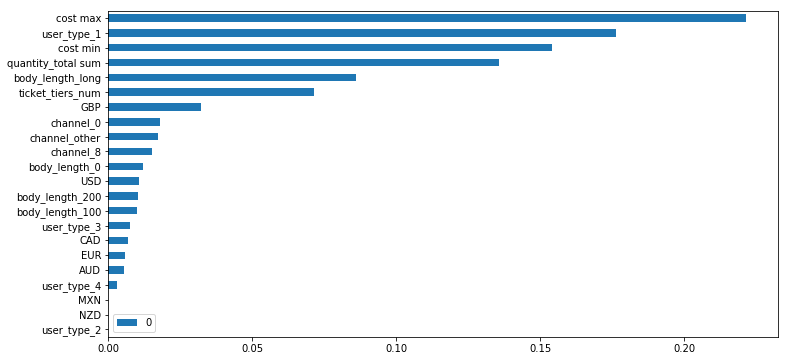

In [750]:
feature_importances = gb.feature_importances_
feature_names = X_train.columns
df = pd.DataFrame(feature_importances, index = feature_names)
df.sort_values(0, inplace = True)
df.plot.barh(figsize = (12, 6))

# Gradient Boosting - Oversample

In [714]:
gbo = GradientBoostingClassifier(learning_rate=.1, 
                                n_estimators=1000, 
                                max_depth = 5, 
                                max_features= 'auto')
model = gbo.fit(X_train_smote, y_train_smote)

pickle.dump(model, open('./src/model.pkl', 'wb'))

In [715]:
score_model(gbo, X_test, y_test, .5)

Precision: 0.73
Recall: 0.68
Accuracy: 0.95
Threshold: 0.50


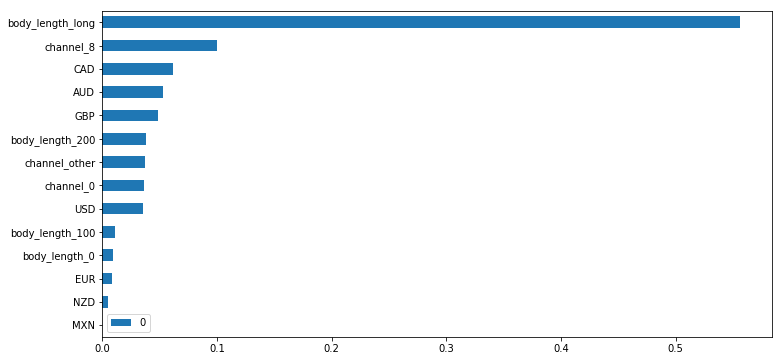

In [559]:
feature_importances = gb.feature_importances_
feature_names = X_train.columns
df = pd.DataFrame(feature_importances, index = feature_names)
df.sort_values(0, inplace = True)
df.plot.barh(figsize = (12, 6))

# Gradient Boosting - Most important features

In [560]:
X_train_important = X_train[['body_length_long', 'channel_0', 'GBP', 'body_length_200']]
X_test_important = X_test[['body_length_long', 'channel_0', 'GBP', 'body_length_200']]
gb = GradientBoostingClassifier(learning_rate=.1, 
                                n_estimators=1000, 
                                max_depth = 5, 
                                max_features= 'auto')
gb.fit(X_train_important, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [524]:
score_model(gb, X_test_important, y_test, .5)

Precision: 0.66
Recall: 0.11
Accuracy: 0.91
Threshold: 0.50


# Web Page Support

#### Fraudify:
* Data Driven Fraud Detection

#### Discover instant benefits:
* Prevent unnecessary losses due to fraudulent activity
* Maximize the impact of your fraud investigation efforts
* Improve customer satisfaction with automated approval of low risk events

# Database setup

In [619]:
with open('/Users/tylerpreston/bin/config/casestudy_rds.conf') as file:
    pw = file.read().strip()

In [680]:
conn = psycopg2.connect(dbname='casestudy', 
                        port = '5432', 
                        user ='Admin1', 
                        host='casestudy.c6isxf0drhi3.us-east-1.rds.amazonaws.com', 
                        password='gschool92')

In [681]:
cur = conn.cursor()

In [682]:
cur.execute('''
CREATE TABLE account(
   user_id serial PRIMARY KEY,
   username VARCHAR (50) UNIQUE NOT NULL,
   password VARCHAR (50) NOT NULL,
   email VARCHAR (355) UNIQUE NOT NULL
);

''')

In [683]:
sql = """INSERT INTO account (user_id, username, password, email)
            VALUES(2345, 'Big Jon Bobo', 'gschool92', 'daniel@vega.com');
            """
cur.execute(sql)

# INSERT INTO books (id, title, author_id, subject_id)
# booktown-#        VALUES (41472, 'Practical PostgreSQL', 1212, 4);

In [685]:
sql = '''
SELECT *
FROM account
'''
cur.execute(sql)

In [686]:
rows = cur.fetchall()

In [687]:
rows

[(2345, 'Big Jon Bobo', 'gschool92', 'daniel@vega.com')]